In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sys
import math

In [3]:
import pywt

In [5]:
from SLIP import Image, imread
from LogGabor import LogGabor

In [6]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [7]:
def mnist_reshape_128(x, i_offset = 0, j_offset = 0):
    assert x.shape == (28 * 28,)
    image = x.reshape(28, 28)
    image = np.append(np.zeros((128 + 2, 28)), image, axis = 0)
    image = np.append(image, np.zeros((128 + 2, 28)), axis = 0)
    image = np.append(np.zeros((288, 128 + 2)), image, axis = 1)
    image = np.append(image, np.zeros((288, 128 + 2)), axis = 1)
    return image[128 + 16 - 64 - i_offset : 128 + 16 + 64 - i_offset, 128 + 16 - 64 - j_offset : 128 + 16 + 64 - j_offset]

In [9]:
def calc_dim(shape, h, h_max):
	assert 0 <= h < h_max
	if h == 0:
		dim_i = int(math.ceil(shape[0] * 1. // 2**(h_max - 1)))
		dim_j = int(math.ceil(shape[1] * 1. // 2**(h_max - 1)))
	else :
		dim_i = int(math.ceil(shape[0] * 1. // 2**(h_max - h)))
		dim_j = int(math.ceil(shape[1] * 1. // 2**(h_max - h)))
	return dim_i, dim_j

In [10]:
class WaveImage:
	
	def __init__(self, image = None, shape = (32, 32)):
		
		# Attribut shape
		if image is not None:
			# Decomposition ondelettes
			coeffs = pywt.wavedec2(image, 'haar')
			self.__shape = image.shape
		else:
			self.__shape = shape
		
		# Attribut h_max : profondeur de l'image
		self.__h_max = min(int(math.log(self.__shape[0], 2)) + 1, 	int(math.log(self.__shape[1], 2)) + 1)
			
		# Attribut data : L'attribut data contient les vecteurs en position [h][u] (dictionnaire)
		if image is not None:
			self.__data = {}
			for h in range(self.__h_max):
				self.__data[h] = {}
				if h == 0:
					(i_max, j_max) = coeffs[h].shape
				else:
					(i_max, j_max) = coeffs[h][0].shape
				for i in range(i_max):
					for j in range(j_max):
						if h == 0:
							data = coeffs[h][i][j]
						else:
							data = coeffs[h][0][i][j]
							for k in range(1,len(coeffs[h])):
								data = np.append(data, coeffs[h][k][i][j])	
						self.__data[h][(i, j)] = data				
		else: # image is None
			self.__data = {}
			for h in range(self.__h_max):
				self.__data[h] = {}
					
		
	def get_data(self):
		return self.__data
	
	def get_shape(self):
		return self.__data
				
	def set_data(self, h, u, v):
		assert 0 <= h < self.__h_max
		dim_i, dim_j = calc_dim(self.__shape, h, self.__h_max)
		assert 0 <= u[0] < dim_i
		assert 0 <= u[1] < dim_j
		if h == 0 :
			self.__data[h][u] = v
		else:
			self.__data[h][u] = np.copy(v)
		
	def get_h_max(self):
		return self.__h_max
		
	def get_image(self):
		coeffs = []
		for h in range(self.__h_max):
			dim_i, dim_j = calc_dim(self.__shape, h, self.__h_max)
			if h == 0:
				coeffs_h = np.zeros((dim_i, dim_j))
				for u in self.__data[h]:
					coeffs_h[u[0],u[1]] = self.__data[h][u]
			else:
				coeffs_h = [np.zeros((dim_i, dim_j)), np.zeros((dim_i, dim_j)), np.zeros((dim_i, dim_j))]
				for u in self.__data[h]:
					for k in range(3):
						coeffs_h[k][u[0],u[1]] = self.__data[h][u][k]
			coeffs += [coeffs_h]
		return pywt.waverec2(coeffs, 'haar')	
		
	def add_coeffs(self, waveImage, u, h_ref = 0):
		# Niveau 0
		h_opp = self.__h_max - 1
		i = int(u[0] // 2**h_opp) 
		j = int(u[1] // 2**h_opp)
		u_0 = (i,j)
		if self.__data[0] == {}:
			self.__data[0][u_0] = waveImage.get_data()[0][u_0]
		else:
			v_test = self.__data[0][u_0]
			if np.linalg.norm(v_test) < 1e-16:
				self.__data[0][u_0] = waveImage.getData()[0][u_0]
		# Niveaux 1 et +
		for h in range(1, h_ref) :
			h_opp = self.__h_max - h
			i = int(u[0] // 2**h_opp) 
			j = int(u[1] // 2**h_opp)
			if (i,j) in self.__data[h]:
				v_test = self.__data[h][(i,j)]
				if np.linalg.norm(v_test) < 1e-16:
					self.__data[h][(i,j)] = np.copy(waveImage.get_data()[h][(i,j)])
			else: 
				self.__data[h][(i,j)] = np.copy(waveImage.get_data()[h][(i,j)])
	
	def copy(self):
		self_shape = self.__shape 
		self_copy = WaveImage(shape = self_shape)
		for h in range(self.__h_max) :
			for u in self.__data[h]:
				self_copy.set_data(h, u, self.__data[h][u])
		return self_copy	
		
	def __str__(self):
		h_max = len(self.__data)
		s = 'h_max :' + str(self.__h_max) + '\n'
		for h in range(self.__h_max):
			s += '***' + str(h) + '***\n'
			s += str(self.__data[h]) + '\n'
		return s


## LogPolar transform

In [21]:
FIG_WIDTH = 12
FIGSIZE=(FIG_WIDTH, .618 * FIG_WIDTH)

In [29]:
param = {
# Image
'N_X' : 128, # size of images
'N_Y' : 128, # size of images
'do_mask'  : True, # used for instance in the Matching Pursuit algorithm self.pe.do_mask
'mask_exponent': 3., #sharpness of the mask
'use_cache' : True,
'verbose': 0,
'figpath': 'results',
'matpath': 'data_cache',
'datapath': 'database',
'figsize': 14.,
'formats': ['pdf', 'svg', 'jpg'],
'dpi': 450,
'seed': None, # a seed for the Random Number Generator (RNG) for picking images in databases, set to None or a given number to freeze the RNG
'N_image': None, # number of images to pick in a database, set to None if you want to pick all in the database
# whitening parameters:
'white_name_database' : 'kodakdb',
'white_n_learning' : 0,
'white_N' : .07,
'white_f_0' : .38, # olshausen = 0.2
'white_alpha' : 1.4,
'white_steepness' : 4.,
'white_recompute' : False,
}


In [229]:
i_offset = 10
j_offset = 10

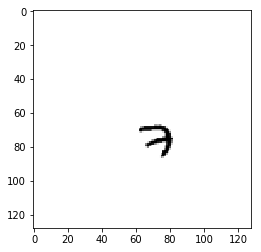

In [230]:
#im = Image(pe='https://raw.githubusercontent.com/bicv/SLIP/master/default_param.py')
im = Image(pe=param)
#im = Image((128, 128))
mnist_sample_offset = mnist_reshape_128(mnist.train.images[0], i_offset = i_offset, j_offset = j_offset)
plt.imshow(mnist_sample_offset, cmap = 'gray_r')

In [231]:
image = mnist_sample_offset
print('Size of image', image.shape)

Size of image (128, 128)


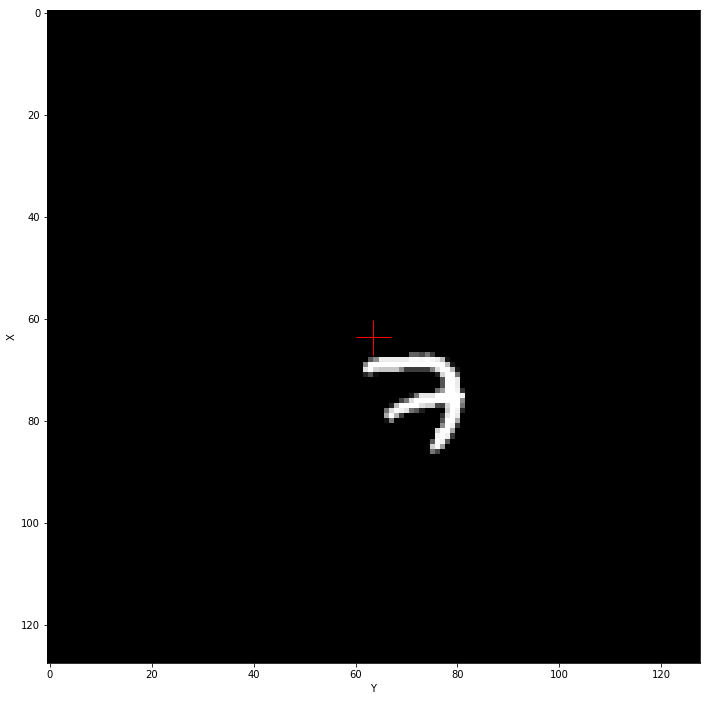

In [232]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
ax.imshow(image, cmap=plt.gray())
center = (63.5, 63.5) # X, Y
ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.plot(center[1], center[0], 'r+', ms=35);

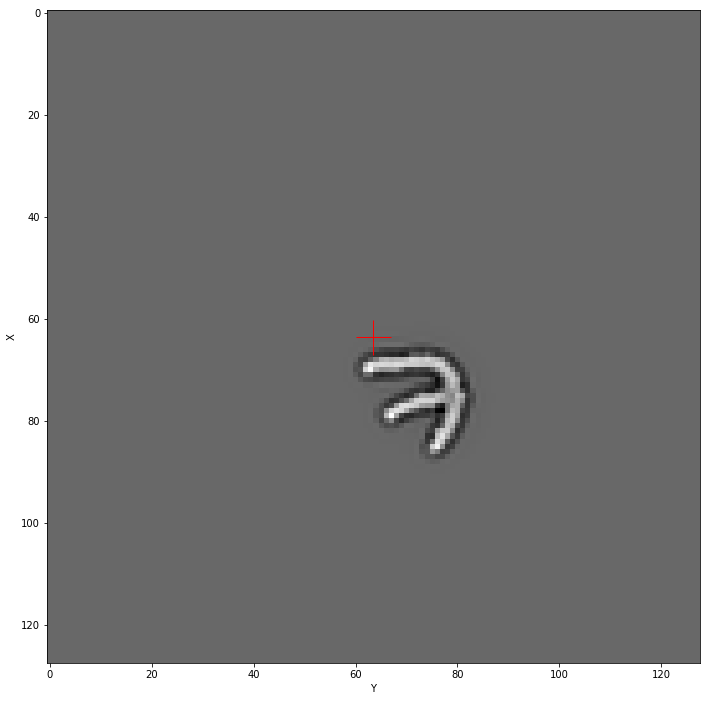

In [233]:
white = im.whitening(image)
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
ax.imshow(white, cmap=plt.gray())
center = (63.5, 63.5) # X, Y
ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.plot(center[1], center[0], 'r+', ms=35);

## LogGabor filters

In [234]:
parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
lg = LogGabor(parameterfile)
lg.set_size((N_X, N_Y))
params= {'sf_0':.1, 'B_sf': lg.pe.B_sf, 'theta':np.pi* 5 / 7., 'B_theta': lg.pe.B_theta}
phase = np.pi/4
edge = lg.normalize(lg.invert(lg.loggabor(N_X/3, 3*N_Y/4, **params)*np.exp(-1j*phase)))

## Vectorizing

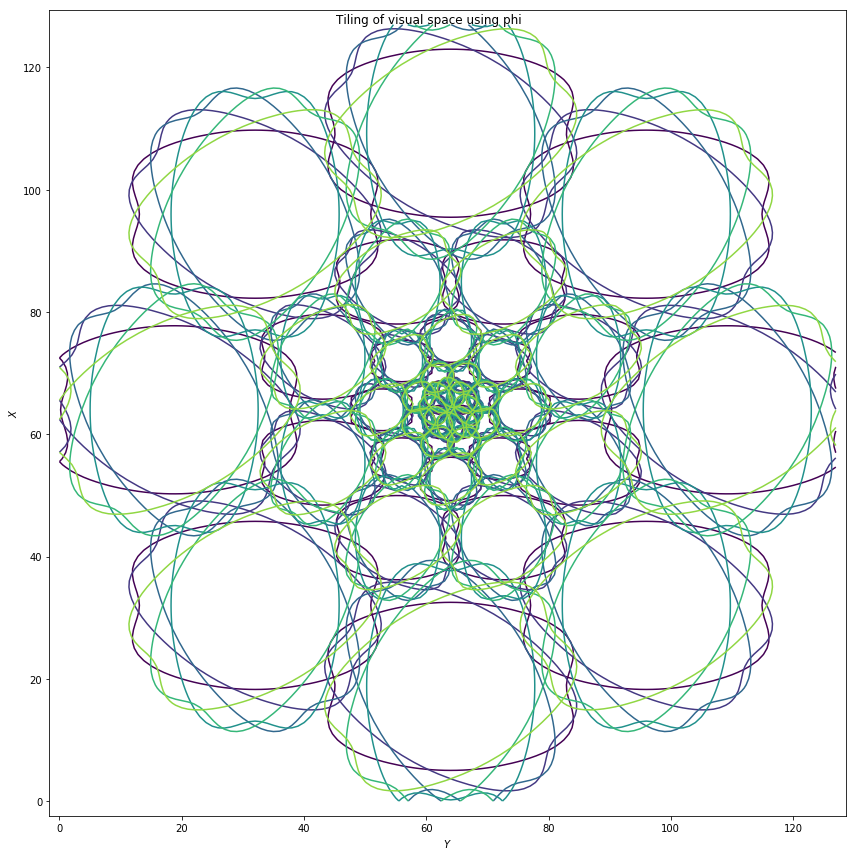

In [235]:
N_X, N_Y = 128, 128
N_theta, N_orient, N_scale, N_phase = 6, 8, 5, 2
phi = np.zeros((N_theta, N_orient, N_scale, N_phase, N_X*N_Y))

for i_theta in range(N_theta):
    for i_orient in range(N_orient):
        for i_scale in range(N_scale):
            ecc =  .5**(N_scale - i_scale)
            r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc # radius
            sf_0 = 0.5 * 0.03 / ecc
            #print('radius=', r, 'at scale', i_scale, 'with sf_0=', sf_0 , 'ecc', ecc)
            x = N_X/2 + r * np.cos((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)
            y = N_Y/2 + r * np.sin((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)            
            for i_phase in range(N_phase):
                params= {'sf_0':sf_0, 'B_sf': lg.pe.B_sf, 'theta':i_theta*np.pi/N_theta, 'B_theta': np.pi/N_theta/2}
                #print('At', i_theta, i_orient, i_scale, i_phase, 'x, y=', x, y, 'params=', params)
                phase = i_phase * np.pi/2
                phi[i_theta, i_orient, i_scale, i_phase, :] = lg.normalize(lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))).ravel()            

fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
for i_theta in range(N_theta):
    for i_orient in range(N_orient):
        for i_scale in range(N_scale):
            env = np.sqrt(phi[i_theta, i_orient, i_scale, 0, :]**2 + phi[i_theta, i_orient, i_scale, 1, :]**2).reshape((N_X, N_Y))
            ax.contour(env, levels=[env.max()/2], lw=1, colors=[plt.cm.viridis(i_theta/(N_theta))])
fig.suptitle('Tiling of visual space using phi')
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout();

## Example

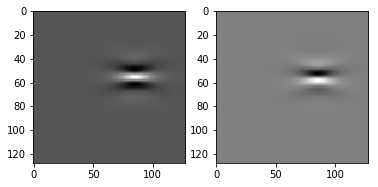

In [236]:
plt.subplot(1,2,1)
plt.imshow(np.reshape(phi[0,2,3,0,:],(128, 128)))
plt.subplot(1,2,2)
plt.imshow(np.reshape(phi[0,2,3,1,:],(128, 128)))

## Encoding

In [237]:
code = phi @ image.ravel()
print('All scalar products in one shot = ', (code).shape )

All scalar products in one shot =  (6, 8, 5, 2)


In [238]:
print('Shape of phi=', phi.shape)
phi_vectorial = phi.reshape((N_theta*N_orient*N_scale*N_phase, N_X*N_Y))
print('Shape of phi_vectorial=', phi_vectorial.shape)
print('Shape of phi=', phi_vectorial.reshape((N_theta, N_orient, N_scale, N_phase, N_X*N_Y)).shape)

Shape of phi= (6, 8, 5, 2, 16384)
Shape of phi_vectorial= (480, 16384)
Shape of phi= (6, 8, 5, 2, 16384)


In [239]:
vectorial_code = phi_vectorial @ image.ravel() # encoding x --> z 

In [240]:
print('Taille du code : ', vectorial_code.shape)

Taille du code :  (480,)


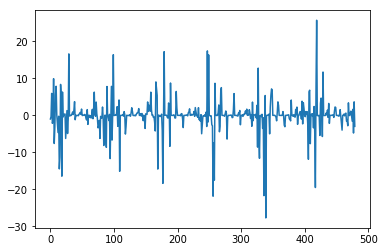

In [241]:
plt.plot(vectorial_code)

## Decoding / visualisation

In [242]:
phi_plus = np.linalg.pinv(phi_vectorial) # pseudo-inverse
image_hat = phi_plus @ vectorial_code # decoding z--> x

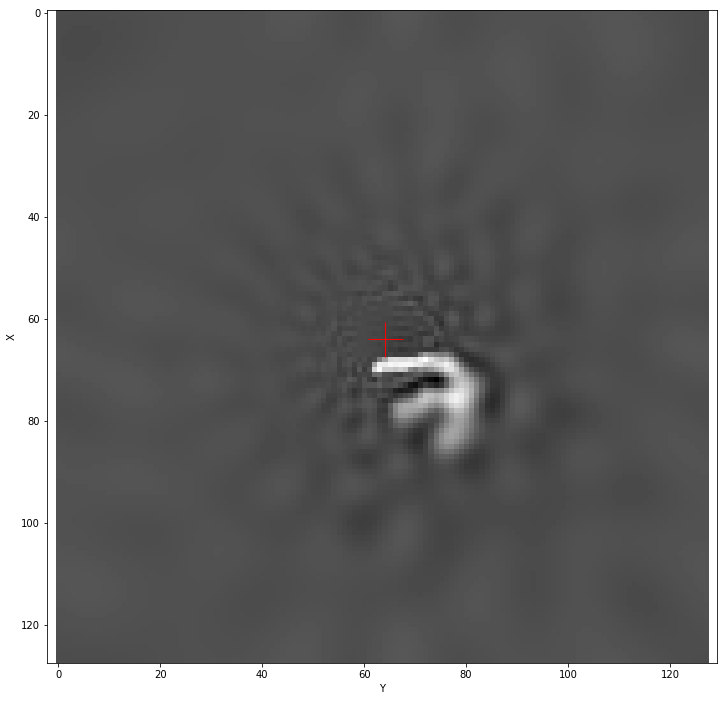

In [243]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
ax.imshow(image_hat.reshape((N_X, N_Y)), cmap=plt.gray())
ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.plot([N_Y/2], [N_X/2], 'r+', ms=35)
ax.axis('equal');

## Energy

In [244]:
energy = (code**2).sum(axis=-1)
print('Shape of energy = ', energy.shape )

Shape of energy =  (6, 8, 5)


In [245]:
global_energy = (code**2).sum(axis=(0, -1))
print('Shape of global_energy = ', global_energy.shape )

Shape of global_energy =  (8, 5)


Shape of color_energy =  (8, 5, 3)


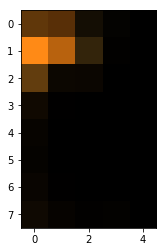

In [246]:
color_energy = np.zeros((N_orient, N_scale, 3))
for i_theta in range(N_theta):
    color = np.array([1 + np.cos(i_theta/N_theta + i*np.pi/3) for i in np.arange(3)])
    color_energy += energy[i_theta, :, :][:, :, np.newaxis] * color[np.newaxis, np.newaxis, :]
print('Shape of color_energy = ', color_energy.shape )
color_energy /= color_energy.max()
r, theta = np.meshgrid(np.linspace(0, 1, N_scale), np.linspace(0, 2*np.pi, N_orient))
fig, ax = plt.subplots()#subplot_kw=dict(projection='polar'))
#ax.pcolormesh(theta, r, color_energy);
ax.imshow(np.fliplr(color_energy));

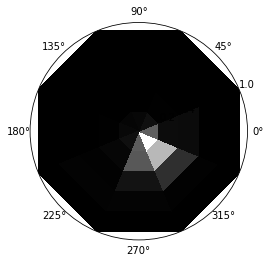

In [252]:
r, theta = np.meshgrid(np.linspace(0, 1, N_scale + 1), np.linspace(-np.pi * .625, np.pi * 1.375, N_orient + 1))
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.pcolor(theta, r, np.fliplr(global_energy));

In [248]:
.25/2

0.125